# Reddit user gender classification

### Libraries and configuration

In [ ]:
from datetime import timedelta as td
from time import time

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, cross_val_score

In [ ]:
plt.style.use(['grid', 'science', 'notebook', 'mylegend'])

data_dir = 'data'

## Load the training and test data

In [ ]:
def load_data(load_test: bool) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_data = pd.read_csv(f'{data_dir}/train_data.csv')
    target = pd.read_csv(f'{data_dir}/train_target.csv')
    if load_test:
        test_data = pd.read_csv(f'{data_dir}/test_data.csv')
    else:
        test_data = pd.DataFrame()
    return train_data, target, test_data

In [ ]:
train_data, target, test_data = load_data(load_test=True)

print(f"Number of authors in training set: {train_data["author"].unique().shape[0]}")

## Feature extraction

In [ ]:
def create_subreddit_idx(data: pd.DataFrame) -> pd.Series:
    """Map every subreddit to a unique integer."""
    subreddits = data["subreddit"].unique()
    return pd.Series(index=subreddits, data=np.arange(len(subreddits)))

In [ ]:
def extract_subreddits(
    author_data: pd.DataFrame,
    subreddit_idx: pd.Series,
) -> sp.csr_array:
    """
    This function converts all the subreddits the author has posted in into a sparse
    array of length N (where N is the number of subreddits in the dataset) with 1s in
    the indexes of the subreddits the author has posted in.
    """
    user_subs = author_data["subreddit"]
    subs_in_idx = user_subs.isin(subreddit_idx.index)
    user_subs = user_subs[subs_in_idx].to_numpy()

    # idxs is an array with the indexes of the subreddits in subreddits_idx
    idxs = subreddit_idx.loc[user_subs].to_numpy()

    # create a sparse array indicating the subreddits the author has posted in
    v = sp.dok_array((1, len(subreddit_idx)))  # dok = dictionary of keys
    for idx in idxs:
        v[0, idx] = 1
    return v.tocsr()  # convert to compressed sparse row format

In [ ]:
def extract_text(author_data: pd.DataFrame) -> str:
    """Returns all the posts of an author as a single string."""
    group_text = author_data["body"].astype(str).to_numpy()
    return " ".join(group_text)

In [ ]:
def vectorize_text(
    vectorizer: TfidfVectorizer,
    text: list[str],
    data_is_test: bool,
) -> sp.csr_array:
    """
    This function vectorizes the text of an author using the provided vectorizer.
    If the data is test data, the vectorizer is only transformed, otherwise it is fit
    and transformed.
    """
    if data_is_test:
        return vectorizer.transform(text)
    else:
        return vectorizer.fit_transform(text)

In [ ]:
def extract_features(
    data: pd.DataFrame,
    subreddit_idx: pd.Series,
    vectorizer: TfidfVectorizer,
    *,
    target: pd.DataFrame | None = None,
) -> tuple[sp.csr_matrix, pd.Series] | sp.csr_matrix:
    """Extract features from the data."""

    data_is_test = True if target is None else False

    subs_dict: dict[str, sp.csr_array] = {}
    for author, group in data.groupby("author"):
        subs_dict[author] = extract_subreddits(group, subreddit_idx)

    if data_is_test:
        authors = data["author"].unique()
    else:
        authors = target["author"]

    # Generate a sparse matrix with the authors as rows
    # and the subreddits they have posted in as columns
    subs_matrix: sp.csr_matrix = sp.vstack([subs_dict[author] for author in authors])

    text_dict: dict[str, str] = {}
    for author, group in data.groupby("author"):
        text_dict[author] = extract_text(group)

    author_text: list[str] = [text_dict[author] for author in authors]
    text_features = vectorize_text(vectorizer, author_text, data_is_test)

    # print(type(text_features))

    X = sp.hstack([subs_matrix, text_features])

    if data_is_test:
        return X
    else:
        y: pd.Series = target["gender"]
        return X, y

In [ ]:
subreddit_idx = create_subreddit_idx(train_data)
vectorizer = TfidfVectorizer(max_df=0.95, stop_words="english", max_features=10000)  # max_features needs to be tuned !!!

In [ ]:
X, y = extract_features(train_data, subreddit_idx, vectorizer, target=target)

### Dataset exploration

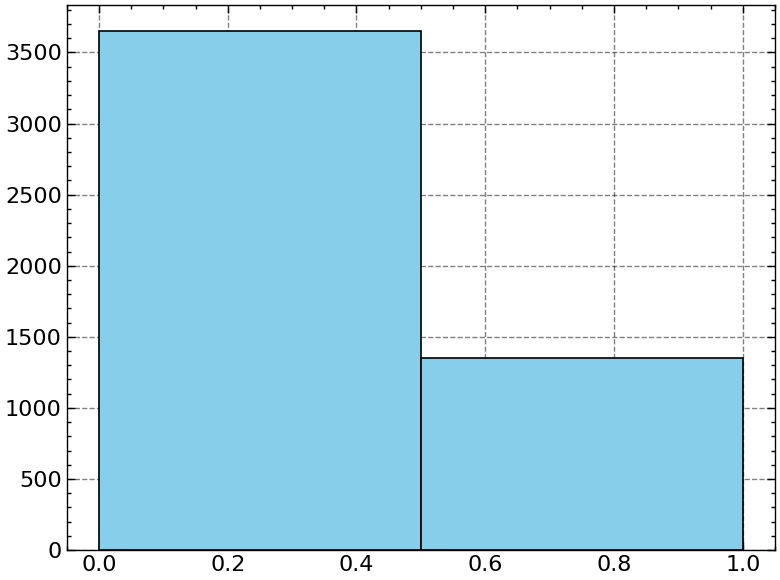

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(target["gender"], bins=2, color="skyblue", edgecolor="black", linewidth=1.2, align="mid")

fig.tight_layout()
plt.show()

The dataset is strongly unbalanced towards the male class.

## Model selection
Define a set of models to try on the dataset. Then, for each model, perform hyperparameters tuning using `GridSearchCV`. Finally, pick the best model overall.

In [ ]:
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.naive_bayes import GaussianNB as NB
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neural_network import MLPClassifier as MLP

classifiers = {"LogReg": LogReg(n_jobs=-1),
               "KNN": KNN(n_jobs=-1),
            #    "Naive Bayes": NB(),
               "Random Forest": RF(n_jobs=-1),
               "Decision Tree": DT(),
               "Gradient Boosting": GBC(solver="adam"),
               "MultiLayer Perceptron": MLP(),
               "SVM": SVC(probability=True),
}

# for name, clf in classifiers.items():
#     print(f"{name} -- parameters: {clf.get_params()}")

In [ ]:
param_grids = [
    {"C": np.logspace(-2, 5)},  # LogReg
    {"n_neighbors": np.arange(1, 20), "weights": ["uniform", "distance"]},  # KNN
    # {},  # Naive Bayes
    {"n_estimators": np.arange(1, 100, 5)},  # Random Forest
    {"max_depth": np.arange(1, 10), "min_samples_split": np.arange(2, 5)},  # Decision Tree
    {  # Gradient Boosting
        "n_estimators": np.arange(1, 20, 4),
        "learning_rate": np.logspace(-3, 0),
        "max_depth": np.arange(1, 5),
    },
    {  # MultiLayer Perceptron
        "hidden_layer_sizes": [(20,), (10, 5), (10, 5, 2)],
        "activation": ["logistic", "relu"],
        "alpha": np.logspace(-4, -2),
        "learning_rate": ["constant", "adaptive"],
        "learning_rate_init": np.logspace(-3, 0),
        "early_stopping": [True, False],
    },
    [  # SVM
        {
            "C": np.logspace(0, 2),
            "kernel": ["linear"],
        },
        {
            "C": np.logspace(0, 2),
            "kernel": ["rbf"],
            "gamma": ["scale", "auto"],
        },
        {
            "C": np.logspace(0, 2),
            "kernel": ["poly"],
            "degree": np.arange(2, 4),
            "gamma": ["scale", "auto"],
        },
    ],
]

In [43]:
# param_grids = [{}] * len(classifiers)

best_clfs = {}
best_pars = {}
for (name, clf), param_grid in zip(classifiers.items(), param_grids):
    print(f"Training {name:21} -- ", end="")
    search = HalvingGridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    t_start = time()
    search.fit(X, y)
    t_end = time()
    best_clfs[name] = search.best_estimator_
    best_pars[name] = search.best_params_
    print(f"score = {search.best_score_:.3f}, time = {td(seconds=t_end - t_start)}")

Training LogReg                -- 

score = 0.909, time = 0:00:08.225849
Training KNN                   -- score = 0.736, time = 0:00:18.724397
Training Random Forest         -- score = 0.842, time = 0:00:45.725016
Training Decision Tree         -- 

KeyboardInterrupt: 

In [ ]:
best_scores_cv = {}
for name, clf in best_clfs.items():
    print(f"Scoring {name:21}", end=" ")
    t_start = time()
    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
    t_end = time()
    best_scores_cv[name] = scores
    print(f"time = {t_end - t_start:.2f}s")

In [ ]:
print("Classifier            Score")
for name, scores in best_scores_cv.items():
    print(f"{name:21} {scores.mean():.3f} +/- {scores.std():.3f}")

In [ ]:
best_scores = {name: (scores.mean(), scores.std()) for name, scores in best_scores_cv.items()}
best_clf_name = max(best_scores, key=lambda k: best_scores[k][0])

In [ ]:
best_clf = best_clfs[best_clf_name]
joblib.dump(best_clf, f"{data_dir}/best_clf.joblib")

## Preparing the solution

In [ ]:
X_test = extract_features(test_data, subreddit_idx, vectorizer)

In [ ]:
y_pred = best_clf.predict_proba(X_test)[:, 1]

In [ ]:
solution = pd.DataFrame({"author": test_data.author.unique(), "gender": y_pred})
solution.head()

In [ ]:
solution.to_csv("submission.csv", index=False)

Now go to [Kaggle](https://www.kaggle.com/competitions/datamining2024/overview), click "Submit Prediction" and upload the file "submission.csv" to see the test score.